# 4. Aproximación de f(x, y, z) = sin(x) + cos(y) + z


Se usa como función de activación la tangente hiperbólica.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

np.random.seed(42)


### Generación de datos

In [10]:

n_train = 2000
n_eval = 400
rng = np.random.default_rng(123)
def sample_xyz(n):
    x = rng.uniform(0, 2 * np.pi, size=(n, 1))
    y = rng.uniform(0, 2 * np.pi, size=(n, 1))
    z = rng.uniform(-1.0, 1.0, size=(n, 1))
    data = np.hstack([x, y, z])
    target = np.sin(x) + np.cos(y) + z
    return data, target
X_train, y_train = sample_xyz(n_train)
X_eval, y_eval = sample_xyz(n_eval)
X_train[:3], y_train[:3]


(array([[4.2873432 , 2.18477294, 0.39188504],
        [0.33816743, 5.93871974, 0.79336782],
        [1.38456191, 6.02518957, 0.18343443]]),
 array([[-1.09525716],
        [ 2.06638275],
        [ 2.13304616]]))

### Red multicapa y backpropagation batch

In [11]:

class MLPRegressor:
    def __init__(self, n_inputs: int, hidden_sizes: List[int], learning_rate: float = 0.01):
        self.learning_rate = learning_rate
        layer_sizes = hidden_sizes + [1]
        self.weights = []
        self.biases = []
        prev = n_inputs
        rng = np.random.default_rng(7)
        for units in layer_sizes:
            limit = np.sqrt(6 / (prev + units))
            self.weights.append(rng.uniform(-limit, limit, size=(prev, units)))
            self.biases.append(np.zeros((1, units)))
            prev = units
        self.train_loss = []
        self.eval_loss = []

    @staticmethod
    def _tanh(x):
        return np.tanh(x)

    @staticmethod
    def _tanh_derivative(x):
        return 1.0 - np.tanh(x) ** 2

    def forward(self, X):
        activations = [X]
        pre_activations = []
        a = X
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            z = a @ W + b
            pre_activations.append(z)
            if i == len(self.weights) - 1:
                a = z
            else:
                a = self._tanh(z)
            activations.append(a)
        return activations, pre_activations

    def predict(self, X):
        a = X
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            z = a @ W + b
            if i == len(self.weights) - 1:
                a = z
            else:
                a = np.tanh(z)
        return a

    def mse(self, y_hat, y):
        return np.mean((y_hat - y) ** 2)

    def train(self, X_train, y_train, X_eval, y_eval, epochs: int = 2000):
        n = X_train.shape[0]
        for _ in range(epochs):
            activations, pre_acts = self.forward(X_train)
            y_hat = activations[-1]
            loss = self.mse(y_hat, y_train)
            self.train_loss.append(loss)
            y_hat_eval = self.predict(X_eval)
            self.eval_loss.append(self.mse(y_hat_eval, y_eval))
            delta = (y_hat - y_train) * (2 / n)
            for layer in reversed(range(len(self.weights))):
                a_prev = activations[layer]
                grad_W = a_prev.T @ delta
                grad_b = np.sum(delta, axis=0, keepdims=True)
                if layer != 0:
                    delta = (delta @ self.weights[layer].T) * self._tanh_derivative(pre_acts[layer - 1])
                self.weights[layer] -= self.learning_rate * grad_W
                self.biases[layer] -= self.learning_rate * grad_b
        return self.train_loss, self.eval_loss

    def train_minibatch(self, X_train, y_train, X_eval, y_eval, epochs: int = 500, batch_size: int = 32, shuffle: bool = True):
        n = X_train.shape[0]
        self.train_loss = []
        self.eval_loss = []
        for _ in range(epochs):
            indices = np.arange(n)
            if shuffle:
                np.random.shuffle(indices)
            for start in range(0, n, batch_size):
                end = start + batch_size
                batch_idx = indices[start:end]
                Xb = X_train[batch_idx]
                yb = y_train[batch_idx]
                activations, pre_acts = self.forward(Xb)
                y_hat = activations[-1]
                delta = (y_hat - yb) * (2 / len(Xb))
                for layer in reversed(range(len(self.weights))):
                    a_prev = activations[layer]
                    grad_W = a_prev.T @ delta
                    grad_b = np.sum(delta, axis=0, keepdims=True)
                    if layer != 0:
                        delta = (delta @ self.weights[layer].T) * self._tanh_derivative(pre_acts[layer - 1])
                    self.weights[layer] -= self.learning_rate * grad_W
                    self.biases[layer] -= self.learning_rate * grad_b
            self.train_loss.append(self.mse(self.predict(X_train), y_train))
            self.eval_loss.append(self.mse(self.predict(X_eval), y_eval))
        return self.train_loss, self.eval_loss



In [ ]:

mlp = MLPRegressor(n_inputs=3, hidden_sizes=[32, 16], learning_rate=0.01)
epochs = 2000
train_loss, eval_loss = mlp.train(X_train, y_train, X_eval, y_eval, epochs=epochs)
print(f"Último Error cuadrático medio de entrenamiento: {train_loss[-1]:.5f}, evaluación: {eval_loss[-1]:.5f}")


Último MSE entrenamiento: 0.11694, evaluación: 0.10349


In [13]:

muestras = 5
y_true = y_eval[:muestras]
y_pred = mlp.predict(X_eval[:muestras])
for i in range(muestras):
    print(f"y_real={y_true[i,0]: .3f} - y_pred={y_pred[i,0]: .3f}")


y_real=-1.138 - y_pred=-0.853
y_real=-1.038 - y_pred=-0.517
y_real=-0.024 - y_pred= 0.146
y_real=-1.437 - y_pred=-0.914
y_real= 0.058 - y_pred=-0.682


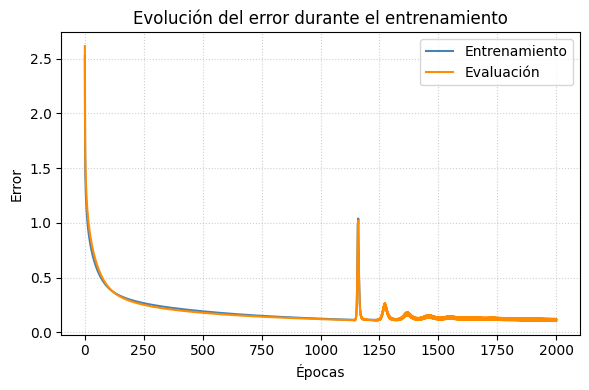

In [14]:

plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_loss, label='Entrenamiento', color='steelblue')
plt.plot(range(1, epochs + 1), eval_loss, label='Evaluación', color='darkorange')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.title('Evolución del error durante el entrenamiento')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


### Variación del tamaño de minibatch (40 muestras)

Red 3 entradas 30 neuronas en la capa oculta y una salida entrenada con 40 ejemplos para comparar minibatch completo vs batch de 1.


In [ ]:

def sample_xyz_from_rng(rng, n):
    x = rng.uniform(0, 2 * np.pi, size=(n, 1))
    y = rng.uniform(0, 2 * np.pi, size=(n, 1))
    z = rng.uniform(-1.0, 1.0, size=(n, 1))
    data = np.hstack([x, y, z])
    target = np.sin(x) + np.cos(y) + z
    return data, target

rng_small = np.random.default_rng(2025)
n_train_small = 40
n_eval_small = 400
X_train_small, y_train_small = sample_xyz_from_rng(rng_small, n_train_small)
X_eval_small, y_eval_small = sample_xyz_from_rng(rng_small, n_eval_small)

mlp_batch40 = MLPRegressor(n_inputs=3, hidden_sizes=[30], learning_rate=0.01)
train_40, eval_40 = mlp_batch40.train_minibatch(
    X_train_small, y_train_small, X_eval_small, y_eval_small,
    epochs=600, batch_size=40
)

mlp_batch1 = MLPRegressor(n_inputs=3, hidden_sizes=[30], learning_rate=0.01)
train_1, eval_1 = mlp_batch1.train_minibatch(
    X_train_small, y_train_small, X_eval_small, y_eval_small,
    epochs=600, batch_size=1
)

print(f'Batch 40 -> Error cuadrático medio final train: {train_40[-1]:.4f}, eval: {eval_40[-1]:.4f}')
print(f'Batch 1 -> Error cuadrático medio final train: {train_1[-1]:.4f}, eval: {eval_1[-1]:.4f}')



Batch 40 -> MSE final train: 0.2825, eval: 0.3479
Batch 1 -> MSE final train: 0.0322, eval: 0.2419


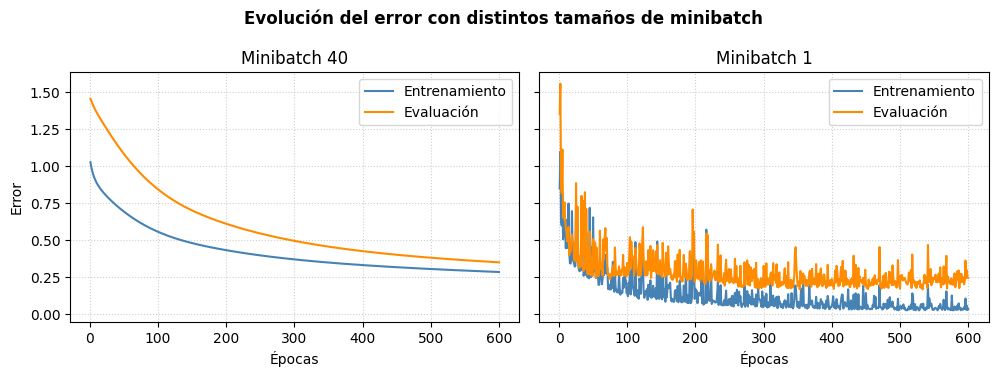

In [18]:

fig, axes = plt.subplots(1, 2, figsize=(10, 3.8), sharey=True)
epochs_axis = range(1, len(train_40) + 1)
axes[0].plot(epochs_axis, train_40, label='Entrenamiento', color='steelblue')
axes[0].plot(epochs_axis, eval_40, label='Evaluación', color='darkorange')
axes[0].set_title('Minibatch 40')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Error')
axes[0].grid(True, linestyle=':', alpha=0.6)
axes[0].legend()

epochs_axis = range(1, len(train_1) + 1)
axes[1].plot(epochs_axis, train_1, label='Entrenamiento', color='steelblue')
axes[1].plot(epochs_axis, eval_1, label='Evaluación', color='darkorange')
axes[1].set_title('Minibatch 1')
axes[1].set_xlabel('Épocas')
axes[1].grid(True, linestyle=':', alpha=0.6)
axes[1].legend()
fig.suptitle('Evolución del error con distintos tamaños de minibatch', fontweight='bold')
plt.tight_layout()
#plt.savefig('TP2/ejercicio-4/evolucion-error-minibatch.png', dpi=150, bbox_inches='tight')
plt.show()

